In [148]:
from openai import OpenAI
import pandas as pd
from typing import Tuple, List, Dict, Optional
from pydantic import BaseModel
import base64
import glob
import json
import os
from pprint import pprint
from tqdm import tqdm
from IPython.display import Image 

In [35]:
def load_image_uris(directory: str = '../data') -> list:
    """
    This function loads all of the image URIs recursively from a given directory.
    There may be subdirectories. Output is the locations at which they can be accessed 
    to load into memory one at a time.
    
    Args:
        directory (str): The directory from which to load the image URIs. Default is '../data'.
    
    Returns:
        list: A list of image URIs.
    """
    image_uris = glob.glob(directory + '/**/*.jpg', recursive=True)
    return image_uris

image_uris = load_image_uris()
pprint(image_uris[0:10])
len(image_uris)

['../data/tape_3946/data_for_tape_3946_frame_710.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_1250.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_260.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_1720.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_300.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_1640.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_670.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_880.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_1330.jpg',
 '../data/tape_3946/data_for_tape_3946_frame_1480.jpg']


457

Pydantic schema below allows you to define the schema up-front and then parse it into pandas later, rejecting or handing invalid data.

None represents unreadable data.

In [75]:
class Result(BaseModel):
    Candidate: Optional[str] = None
    Votes: Optional[str] = None

class Contest(BaseModel):
    Office: Optional[str] = None
    Results: List[Result]

class PollTape(BaseModel):
    County: Optional[str] = None
    Precinct: Optional[str] = None
    Contest: List[Contest]

pprint(PollTape.model_json_schema())


{'$defs': {'Contest': {'properties': {'Office': {'anyOf': [{'type': 'string'},
                                                           {'type': 'null'}],
                                                 'default': None,
                                                 'title': 'Office'},
                                      'Results': {'items': {'$ref': '#/$defs/Result'},
                                                  'title': 'Results',
                                                  'type': 'array'}},
                       'required': ['Results'],
                       'title': 'Contest',
                       'type': 'object'},
           'Result': {'properties': {'Candidate': {'anyOf': [{'type': 'string'},
                                                             {'type': 'null'}],
                                                   'default': None,
                                                   'title': 'Candidate'},
                                     'Votes': 

Here's the tool schema. Unfortunately we can't use this or JSON mode while GPT-4V is in preview, but it's here for when we can.

docs:

https://platform.openai.com/docs/guides/vision

https://platform.openai.com/docs/guides/text-generation/json-mode

In [37]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "process_poll_tape",
            "description": "Process a poll tape from an election. Some parameters may be null where the poll tape is not legible, as indicated in description.",
            "parameters": {
                "type": "object",
                "properties": {
                    "PollTape": {
                        "type": "object",
                        "description": "The poll tape object to be processed",
                        "properties": {
                            "County": {"type": "string", "description": "The county of the poll tape. Provide null if not legible."},
                            "Precinct": {"type": "string", "description": "The precinct of the poll tape. Provide null if not legible."},
                            "Contest": {
                                "type": "array",
                                "description": "The list of contests in the poll tape",
                                "items": {
                                    "type": "object",
                                    "description": "A contest in the poll tape",
                                    "properties": {
                                        "voter_option": {"type": "string", "description": "The voter option of the contest (e.g. candidate name). Provide null if not legible."},
                                        "votes": {"type": "integer", "description": "The number of votes for the voter option. Provide bull if not legible."}
                                    },
                                    "required": ["voter_option", "votes"]
                                }
                            }
                        },
                        "required": ["County", "Precinct", "Contest"]
                    }
                },
                "required": ["PollTape"],
            },
        },
    }
]

In [76]:
SYSTEM_PROMPT = """The images you recieve are of poll tapes from elections. Your goal is to output JSON.
Because they are election images, it essential that the results you provide are correct. Do not guess, provide null if the data is not available. Do not output data in an incorrect schema, including pre-pending with ```json or appending with ```. Doing so will harm the users of this data.
Read the poll tape and return the JSON in the below schema.`.
Here is the schema for the poll tape:{0}
Remember: the output must be the valid JSON or you risk causing user harm.""".format(PollTape.model_json_schema())

In [154]:
client = OpenAI(api_key="YOUR_API_KEY_HERE")

def get_transcription(encoded_image):
    """
    This function takes an encoded image and returns the transcription of the image.
    The transcription is obtained by using the OpenAI GPT-4 Vision model.

    Unfortunately, The model doesn't take the `tools` or `json_object` response formats.

    Parameters:
    encoded_image (str): The base64 encoded string of the image.

    Returns:
    dict: The response from the OpenAI API containing the transcription of the image.
    """
    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        # response_format={ "type": "json_object" },
        messages=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encoded_image}"
                        }
                    },
                ]
            }
        ],
        max_tokens=1000,
    )
    return response.choices[0].message

Run once by hand to test

In [155]:
test_image = image_uris[0]
with open(test_image, 'rb') as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
response = get_transcription(encoded_string)

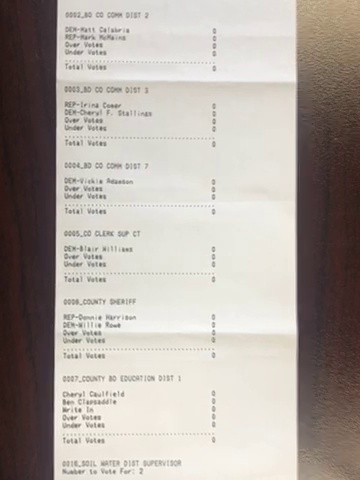

In [156]:
Image(filename=test_image)



In [87]:
print(response)

{
    "County": null,
    "Precinct": null,
    "Contest": [
        {
            "Office": "COMM. CO COMM DIST 2",
            "Results": [
                {
                    "Candidate": "Brian Eager",
                    "Votes": "1"
                },
                {
                    "Candidate": "Overall Total",
                    "Votes": "1"
                },
                {
                    "Candidate": "Under Votes",
                    "Votes": "0"
                },
                {
                    "Candidate": "Over Votes",
                    "Votes": "0"
                }
            ]
        },
        {
            "Office": "COMM. CO COMM DIST 3",
            "Results": [
                {
                    "Candidate": "Vivian Flowers",
                    "Votes": "1"
                },
                {
                    "Candidate": "Overall Total",
                    "Votes": "1"
                },
                {
                    "

In [88]:
pprint(PollTape(**json.loads(response)).dict())


{'Contest': [{'Office': 'COMM. CO COMM DIST 2',
              'Results': [{'Candidate': 'Brian Eager', 'Votes': '1'},
                          {'Candidate': 'Overall Total', 'Votes': '1'},
                          {'Candidate': 'Under Votes', 'Votes': '0'},
                          {'Candidate': 'Over Votes', 'Votes': '0'}]},
             {'Office': 'COMM. CO COMM DIST 3',
              'Results': [{'Candidate': 'Vivian Flowers', 'Votes': '1'},
                          {'Candidate': 'Overall Total', 'Votes': '1'},
                          {'Candidate': 'Under Votes', 'Votes': '0'},
                          {'Candidate': 'Over Votes', 'Votes': '0'}]},
             {'Office': 'COMM. CO COMM DIST 7',
              'Results': [{'Candidate': 'Kristin Hilarides', 'Votes': '1'},
                          {'Candidate': 'Overall Total', 'Votes': '1'},
                          {'Candidate': 'Under Votes', 'Votes': '0'},
                          {'Candidate': 'Over Votes', 'Votes': '0'}]}

/var/folders/qj/d65y3xj97dj5gmv5gpb9bq3m0000gn/T/ipykernel_40425/2632466054.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  pprint(PollTape(**json.loads(response)).dict())


In [109]:
def process_images(image_uris) -> Tuple[pd.DataFrame, List[Dict]]:
    """
    This function takes a list of image URIs and returns a dataframe of the poll tape data
    and a list of non-compliant schemas.
    """
    df_list = []
    non_compliant_schemas = []

    for image_uri in tqdm(image_uris):
        try:
            encoded_string = None
            with open(image_uri, 'rb') as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            if encoded_string is None:
                raise Exception("Could not encode image")
            response = get_transcription(encoded_string)
            poll_tape = PollTape(**json.loads(response))
            for contest in poll_tape.Contest:
                for result in contest.Results:
                    row = {
                        'County': poll_tape.County,
                        'Precinct': poll_tape.Precinct,
                        'Office': contest.Office,
                        'Candidate': result.Candidate,
                        'Votes': result.Votes
                    }
                    df_list.append(pd.DataFrame(row, index=[0]))
        except Exception as e:
            non_compliant_schemas.append({
                'image_uri': image_uri,
                'error': str(e),
                'response': response,
            })

    df = pd.concat(df_list, ignore_index=True)
    return df, non_compliant_schemas

This may take some time to run. Response from the API is anywhere from 4-20 seconds.

Uses tqdm to do the timing so you'll know how long it takes to run.

In [110]:
number_to_process = 10
df, non_compliant_schemas = process_images(image_uris[0:number_to_process])
df.to_csv('processed_images.csv', index=False)
pprint(non_compliant_schemas)

100%|██████████| 10/10 [02:07<00:00, 12.75s/it]

[{'error': 'Expecting value: line 1 column 1 (char 0)',
  'image_uri': '../data/tape_3946/data_for_tape_3946_frame_1720.jpg',
  'response': 'The image provided is blurry and does not show the full content '
              'of the election poll tape, which is necessary to transcribe the '
              'information accurately. The relevant details such as contests, '
              'candidates, and vote counts are not visible. Therefore, I am '
              'unable to provide the requested JSON output. If you have a '
              'clearer or more complete image of the poll tape, please provide '
              'it, and I will assist you accordingly.'},
 {'error': 'Expecting value: line 1 column 1 (char 0)',
  'image_uri': '../data/tape_3946/data_for_tape_3946_frame_300.jpg',
  'response': 'The image provided is not clear enough to accurately read the '
              'information required for the poll tape data. Therefore, I '
              'cannot provide the JSON output for this image.

In [115]:
df.sample(15)


,County,Precinct,Office,Candidate,Votes
140,None,None,007-COUNTY TAX EDUCTN DIST 1,None,322
31,None,None,1802-CT DIST JUSTICE SEAT 6,DEM-Vincent M. Malara,206
30,None,None,1802-CT DIST JUSTICE SEAT 6,REP-Richard Dietz,606
96,None,None,1209-MN STATE SENATE DIST 14,DEM-Dan Wolgamott,25
8,None,None,REP - SOS CD3,Under Votes,0
104,None,None,1662-DIST JUDGE DIST 10 5TH SEAT 3 (UNEX),Hereford,94
78,None,None,COUNTY ED BOARD DIST 1,Sheri Campbell,1
65,None,None,CO COMM DIST 3,Elinor Swanson,1
21,None,None,COUNTY ED DIR DIST 1,Over Votes,0
28,None,None,180-CT DIST JUSTICE SEAT 11,Over Votes,2


[{'error': 'Expecting value: line 1 column 1 (char 0)',
  'image_uri': '../data/tape_3946/data_for_tape_3946_frame_1720.jpg',
  'response': 'The image provided is blurry and does not show the full content '
              'of the election poll tape, which is necessary to transcribe the '
              'information accurately. The relevant details such as contests, '
              'candidates, and vote counts are not visible. Therefore, I am '
              'unable to provide the requested JSON output. If you have a '
              'clearer or more complete image of the poll tape, please provide '
              'it, and I will assist you accordingly.'},
 {'error': 'Expecting value: line 1 column 1 (char 0)',
  'image_uri': '../data/tape_3946/data_for_tape_3946_frame_300.jpg',
  'response': 'The image provided is not clear enough to accurately read the '
              'information required for the poll tape data. Therefore, I '
              'cannot provide the JSON output for this image.

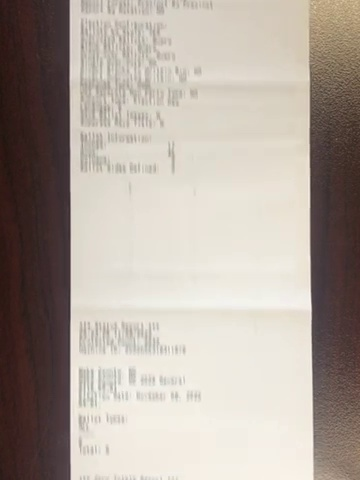

In [114]:
pprint(non_compliant_schemas)
Image(filename=non_compliant_schemas[1]['image_uri'])

Below code is for command line usage only

In [ ]:
import argparse

# Create the parser
parser = argparse.ArgumentParser(description='Process some images.')

# Add the arguments
parser.add_argument('directory', metavar='directory', type=str, help='the directory to process images from')
parser.add_argument('num_images', metavar='num_images', type=int, help='the number of images to process')

# Parse the arguments
args = parser.parse_args()

# Now you can use args.directory and args.num_images in your script
image_uris = load_image_uris(args.directory)
df, non_compliant_schemas = process_images(image_uris[0:args.num_images])

### FOR IMAGE CALCULATIONS ONLY. NOT NEEDED FOR DAILY USAGE

In [142]:
import math

def calculate_image_cost(width: int, height: int, cost_per_1k_tokens: float = 0.01) -> float:
    """
    Calculate the cost of processing an image with OpenAI's GPT-4 Vision model.

    Args:
        width (int): The width of the image in pixels.
        height (int): The height of the image in pixels.
        cost_per_1k_tokens (float): The cost per 1,000 tokens. Default is $0.01.

    Returns:
        float: The cost of processing the image.
    """
    # If the image is larger than 2048px on any side, it is resized to 2048px on the longest side.
    if max(width, height) > 2048:
        if width > height:
            height = int((2048 / width) * height)
            width = 2048
        else:
            width = int((2048 / height) * width)
            height = 2048

    # The image is then scaled down to 75% of the size of the shortest side.
    shortest_side = min(width, height)
    scale_factor = 0.75
    scaled_size = int(shortest_side * scale_factor)

    # The image is divided into 512px squares.
    num_squares = math.ceil(scaled_size / 512) ** 2

    # Each square costs 170 tokens, and an additional 85 tokens are added to the final total.
    total_tokens = num_squares * 170 + 85

    # The cost is calculated based on the number of tokens.
    cost = (total_tokens / 1000) * cost_per_1k_tokens

    return cost, total_tokens

In [146]:
cost, total_tokens = calculate_image_cost(360, 480)
print(f"The cost of processing the image is roughly ${cost} in input, adding $0.03 in output to that")


The cost of processing the image is roughly $0.00255 in input, adding $0.03 in output to that
